<div style="text-align: center; font-size: 30px; color: blue; font-family: 'Arial', sans-serif;">
    <b>"Optimización de la Selección de Pozos Petrolíferos en Regiones Prospectivas: Un Enfoque Basado en Modelos Predictivos y Análisis de Riesgo"</b>
</div>

# Contenido <a id='back'></a>

* [Introducción](#intro)
* [Etapa 1. Carga y Exploración de los Datos](#data_review)
    * [1.1 Descripción de los Datos](#data_review)
* [Etapa 2. Preparación de los Datos](#data_preparing)
    * [2.1 División del conjunto de entrenamiento y de prueba](#data_divisions)
    * [2.2 Visualización de los resultados del modelo de Regresión Lineal](#data_model)
    * [2.3 Estimación de ganancias necesarias para la rentabilidad de los pozos petroleros](#ganancias_pozos)
    * [Conclusiones de la Etapa 2](#conclusions_etapa2)
* [Etapa 3. Cálculos de ganancia en los 200 pozos petrolíferos](#data_petroleo)
    * [3.1 Selección de los 200 pozos petrolíferos mas rentables de cada una de las tres regiones](#choose_good_pozos)
    * [3.2 Utilización de técnica bootstrapping para verificar las ganancias totales de los 200 pozos petrolíferos seleccionados por región](#bootstrapping)
    * [Conclusión de la etapa 3](#etapa3_conclusión)
* [Conclusiones finales del proyecto](#end)

# Etapa 1. Carga y Exploración de los Datos <a id=data_review></a>

In [51]:
# Cargamos los módulos a utilizar, e importamos funciones específicas de módulos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegressionr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Introducción <a id=intro></a>
La compañía petrolera OilyGiant enfrenta un desafío clave: identificar las ubicaciones más rentables para la apertura de 200 nuevos pozos de petróleo en tres regiones con potencial. La selección de estos pozos debe maximizar el retorno de inversión al tiempo que minimiza los riesgos asociados. Con el avance en el análisis de datos y los modelos predictivos, ahora es posible abordar esta tarea con una precisión significativa.

Este proyecto tiene como objetivo desarrollar un modelo predictivo basado en regresión lineal para estimar el volumen de reservas en cada pozo y seleccionar los 200 mejores puntos en términos de rentabilidad dentro de cada región. Para la evaluación del beneficio y del riesgo, se utiliza la técnica de bootstrapping, la cual permite obtener estimaciones robustas del beneficio esperado y el riesgo de pérdidas para cada región. Esto asegura que la selección final cumpla con criterios de beneficio elevado y riesgo reducido.

Finalmente, el análisis permitirá a OilyGiant tomar decisiones informadas para invertir de manera estratégica, mejorando así la eficiencia en la extracción de petróleo y optimizando el retorno sobre su presupuesto de 100 millones de dólares para este proyecto.

In [8]:
# Cargamos los conjuntos de datos, como tenemos 3 regiones, pondremos un nombre descriptivo a cada una de ellas
region_first = pd.read_csv('/home/josue/Aprendizaje_automatico_en_negocios/geo_data_0.csv') 
region_second = pd.read_csv('/home/josue/Aprendizaje_automatico_en_negocios/geo_data_1.csv')
region_third = pd.read_csv('/home/josue/Aprendizaje_automatico_en_negocios/geo_data_2.csv')

## 1.1 Descripción de los Datos <a id='data_review'></a>

In [11]:
# Lista de DataFrames y nombres descriptivos
regions = region_first, region_second, region_third
regions_name = ['Región 1', 'Región 2', 'Región 3']
for region, name in zip(regions, regions_name):
    print(f"************* {name} *************")
    print('Observación de las primeras filas de los conjuntos de datos:\n ', region.head())
    print("\n")
    print('Dimensiones del conjunto de Datos: ', region.shape)
    print('\n')
    print(region.info())
    print('\n')
    print('Distribución de valores en la columna product')
    if 'product' in region.columns:
        print(region['product'].value_counts())
    print("\n" + "="*60 + "\n")
    

************* Región 1 *************
Observación de las primeras filas de los conjuntos de datos:
        id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647


Dimensiones del conjunto de Datos:  (100000, 5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Distribución de valores en la columna product
product
105.280062    1
122.799517    1
61.817308     1

En esta parte observamos información importante sobre los 3 conjuntos de datos(regiones), vemos que los nombres de columnas se encuentran normalizadas, también no hay valores ausentes, también el tipo de datos de los conjuntos de datos es correcto.

# Etapa 2 Preparación de los Datos <a id=data_preparing></a>

## 2.1 División del conjunto de entrenamiento y de prueba <a id=data_divisions></a>

In [24]:
# Como sabemos el objetivo es evaluar 3 zonas, para encontrar cual es la mejor en cuanto gasto-beneficio, por lo tanto vamos a crear funciones, que posteriormente vamos a encapsular, para poder reutilizar nuestro código.

# Función dividir datos
def dividir_datos(region):
    features = region.drop(['id','product'], axis=1)
    target = region['product']
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)
    return features_train, features_test, target_train, target_test

def entrenar_modelo(features_train, target_train, features_test):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicciones = model.predict(features_test)
    return predicciones

def evaluar_modelo(predicciones, target_test):
    rmse = np.sqrt(mean_squared_error(target_test, predicciones))
    volumen_medio = predicciones.mean()
    return rmse, volumen_medio

def procesar_region(region):
    features_train, features_test, target_train, target_test = dividir_datos(region)
    predicciones = entrenar_modelo(features_train, target_train, features_test)
    volumen_medio, rmse = evaluar_modelo(predicciones, target_test)
    print(f"Volumen medio de reservas predicho: {volumen_medio}")
    print(f"RMSE del modelo: {rmse}")
    return predicciones, volumen_medio

## 2.2 Visualización de los resultados del modelo de Regresión Lineal <a id='data_model'></a>

In [25]:
# Imprimir los resultados del modelo LogisticRegression
print("Resultados para la Región 0")
predicciones_0, target_0 = procesar_region(region_first)

print("Resultados para la Región 0")
predicciones_1, target_1 = procesar_region(region_second)

print("Resultados para la Región 0")
predicciones_2, target_2 = procesar_region(region_third)


Resultados para la Región 0
Volumen medio de reservas predicho: 37.5794217150813
RMSE del modelo: 92.59256778438035
Resultados para la Región 0
Volumen medio de reservas predicho: 0.8930992867756165
RMSE del modelo: 68.72854689544602
Resultados para la Región 0
Volumen medio de reservas predicho: 40.02970873393434
RMSE del modelo: 94.96504596800489


## 2.3 Estimación de ganancias necesarias para la rentabilidad de los pozos petroleros <a id='ganancias_pozos'></a>

In [28]:
# Cálculo de ganancias
costo_total_inversion = 100_000_000
pozos_necesarios = 200
ganancia_por_unidad = 4500

# Calcular el valor mínimo de reservas necesario para evitar pérdidas
ganancia_minima_por_pozo = costo_total_inversion / pozos_necesarios
volumen_minimo_reservas = ganancia_minima_por_pozo / ganancia_por_unidad

print(f"Ganancia mínima por pozo para evitar pérdidas: {ganancia_minima_por_pozo} USD")
print(f"Volumen mínimo de reservas necesario por pozo para evitar pérdidas: {volumen_minimo_reservas} unidades (en miles de barriles)")

Ganancia mínima por pozo para evitar pérdidas: 500000.0 USD
Volumen mínimo de reservas necesario por pozo para evitar pérdidas: 111.11111111111111 unidades (en miles de barriles)


In [30]:
# Visualizar que regiones son rentables
volumen_medio_regiones = [predicciones_0.mean(), predicciones_1.mean(), predicciones_2.mean()]

for i, volumen_medio in enumerate(volumen_medio_regiones, start=1):
    print(f"Región {i}: Volumen medio de reservas predicho = {volumen_medio}")
    if volumen_medio >= volumen_minimo_reservas:
        print(f"La Región {i} es rentable según el volumen mínimo requerido.")
    else:
        print(f"La Región {i} NO es rentable según el volumen mínimo requerido.")

Región 1: Volumen medio de reservas predicho = 92.59256778438035
La Región 1 NO es rentable según el volumen mínimo requerido.
Región 2: Volumen medio de reservas predicho = 68.72854689544602
La Región 2 NO es rentable según el volumen mínimo requerido.
Región 3: Volumen medio de reservas predicho = 94.96504596800489
La Región 3 NO es rentable según el volumen mínimo requerido.


## Conclusiones de la Etapa 2 <a id='conclusiones_etapa2'></a>

Como se observo en el paso anterior, tenemos tres regiones diferentes, en las cuales existen registros, dichos registros pasados nos servirán para saber y conocer donde es la mejor región para los 200 pozos que desea abrir la empresa en un futuro. Para tener un código limpio, creamos tres funciones con otra que encapsulo a estas, con el objetivo de dividir los datos, entrenar el modelo y obtener las predicciones, mediante la Regresión Lineal. Para después con la función encapsulada, obtener los entrenamientos con cada una de las tres regiones. 

Los resultados que se obtuvieron fueron interesantes, puesto que primero obtuvimos el volumen medio de reservas petroleras en cada una de las regiones, recalcando que este cálculo fue abarcando todos los pozos petroleros de cada región, es decir decir su volumen medio completo.

En la región 1 y 3, el volumen de reservas estuvieron por encima de las 35,000 mil barriles, mientras que en la región 2, nos sorprendió ver un nivel muy bajo de reservas, seguro en esta region se encuentran muchos pozos de petroleo con una muy baja reserva. 

Por otro lado, también calculamos el RMSE(Root Mean Squared Error), el cual es muy grande, prácticamente el doble, lo cual nos dice en la region 1 que tenemos un volumen medio de 37.57 miles de barriles, se desvían en aproximadamente 92.59 miles de barriles, los cual es mas del doble, y asi es parecido para las demás regiones.

Con estas predicciones, es absolutamente nada recomendable invertir en estas regiones aparentemente, de acuerdo a los resultados que se han obtenido, ninguna de las tres regiones alcanza el volumen mínimo de reservas necesario para evitar pérdidas, que es 111.1 unidades (miles de barriles). Sin embargo, esto no significa que el proyecto no pueda ser rentable en absoluto. Ahora que sabemos que, en promedio, los pozos en estas regiones no cumplen con el umbral mínimo de manera general, el siguiente paso es evaluar si una selección más precisa de pozos dentro de cada región puede llevarnos a la rentabilidad.

# Etapa 3. Cálculo de ganancia en los 200 pozos petrolíferos <a id='data_petroleo'></a>

## 3.1 Selección de los 200 pozos petrolíferos mas rentables de cada una de las tres regiones <a id='choose_good_pozos'></a>

In [74]:
# Vamos a seleccionar los 200 pozos mas rentables, y ver si así, es factible invertir en ellos

# Creación de función de pozos mas rentables

def seleccionar_top_200(predicciones):
    datos = pd.DataFrame({'Predicciones': predicciones})
    top_200 = datos.nlargest(200, 'Predicciones')
    top_200_predicciones = top_200['Predicciones'].values
    return top_200_predicciones

def calcular_ganancias(predicciones, ganancia_total):
    volumen_total = predicciones.sum()
    ganancia_total = volumen_total * ganancia_total
    return ganancia_total

ganancia_por_unidad = 4500

# Crear un diccionario para almacenar las predicciones de los 200 pozos más rentables por región
top_200_predicciones_por_region = {}

# Cálculo de ganancias por región y almacenamiento de los 200 pozos seleccionados
ganancias_por_region = []

for i, predicciones in enumerate([predicciones_0, predicciones_1, predicciones_2], start=1):
    print(f"\nCálculo de ganancia en la región {i}")

    # Seleccionar los 200 pozos con más ganancias
    top_200 = seleccionar_top_200(predicciones)
    
    # Almacenar las predicciones de los 200 pozos seleccionados
    top_200_predicciones_por_region[i] = top_200  # Guardamos en un diccionario con la región como clave

    # Obtener las ganancias
    ganancias_obtenidas = calcular_ganancias(top_200, ganancia_por_unidad)

    # Almacenar las ganancias
    ganancias_por_region.append(ganancias_obtenidas)

    print(f"Ganancias total de la región {i} fue de {ganancias_obtenidas}")

print("\nGanancias por región:", ganancias_por_region)


Cálculo de ganancia en la región 1
Ganancias total de la región 1 fue de 139960488.77465123

Cálculo de ganancia en la región 2
Ganancias total de la región 2 fue de 124857120.51973563

Cálculo de ganancia en la región 3
Ganancias total de la región 3 fue de 133217543.96243261

Ganancias por región: [139960488.77465123, 124857120.51973563, 133217543.96243261]


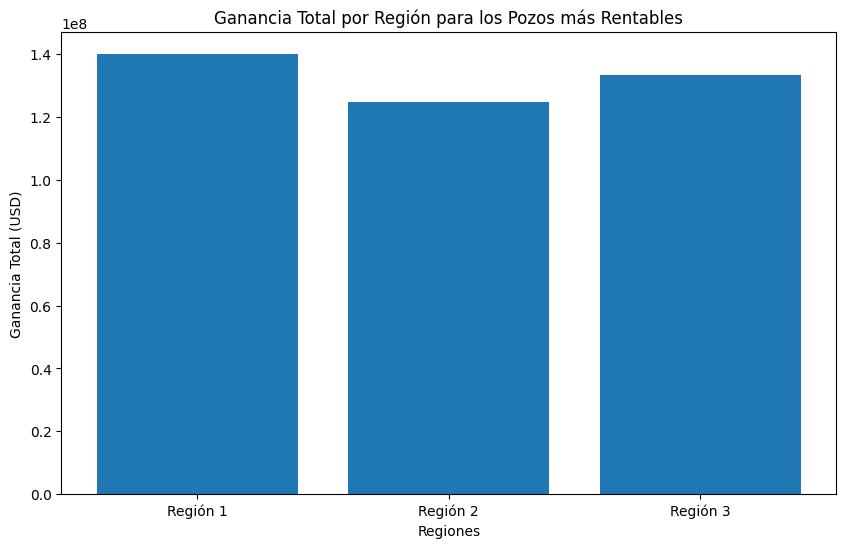

In [52]:
# Creación de gráfico de las ganancias de las regiones

# Nombres de las regiones para el gráfico
regiones = ["Región 1", "Región 2", "Región 3"]

# Creación del gráfico de barras para mostrar las ganancias por región
plt.figure(figsize=(10, 6))
plt.bar(regiones, ganancias_por_region) 
plt.title("Ganancia Total por Región para los Pozos más Rentables")
plt.xlabel("Regiones")
plt.ylabel("Ganancia Total (USD)")
plt.show()

En esta parte logramos con la ayuda de dos funciones primero separar los 200 pozos petrolíferos mas rentables de cada región, y, después estimar su ganancia en miles de dólares. De acuerdo a esta información, si seleccionáramos la región 1, obtendríamos mas de USD 139,000,000.00 millones de dólares, lo cual nos daría una ganancia considerable, en relación a los USD 100,000,000.00 millones que queremos recuperar.

## 3.2 Utilización de técnica bootstrapping para verificar las ganancias totales de los 200 pozos petrolíferos seleccionados por región <a id='bootstrapping'></a>

In [76]:
# Función para calcular riesgos y ganancias por región con bootstrapping

def calcular_bootstrapping(predicciones_top_200, ganancia_unidad, n_bootstraps):
    ganancias_bootstraps = []
    for _ in range(n_bootstraps):
        muestra = np.random.choice(predicciones_top_200, size=len(predicciones_top_200), replace=True)
        volumen_total_muestra = muestra.sum()
        ganancia_muestra = volumen_total_muestra * ganancia_unidad
        ganancias_bootstraps.append(ganancia_muestra)
    return np.array(ganancias_bootstraps)
    

def calcular_estadisticas_ganancia(ganancias_bootstraps):
    beneficio_promedio = ganancias_bootstraps.mean()
    intervalo_confianza = np.percentile(ganancias_bootstraps, [2.5, 97.5])
    riesgo_perdida = (ganancias_bootstraps < 0).mean() * 100
    return beneficio_promedio, intervalo_confianza, riesgo_perdida

ganancias_bootstrap_region = []

for i in range(1, 4):
    top_200_predicciones_ok = top_200_predicciones_por_region[i]
    print(f"\nAnálisis de riesgo y ganancia para la Región {i}")
    
    # Generar la distribución de ganancias con bootstrapping
    ganancias_bootstrap = calcular_bootstrapping(top_200_predicciones_ok, 4500, 1000)
    
    # Calcular estadísticas de la distribución
    beneficio_promedio, intervalo_confianza, riesgo_perdida = calcular_estadisticas_ganancia(ganancias_bootstrap)
    
    # Imprimir los resultados
    print(f"Beneficio promedio: {beneficio_promedio} USD")
    print(f"Intervalo de confianza del 95%: {intervalo_confianza} USD")
    print(f"Riesgo de pérdida: {riesgo_perdida}%")


Análisis de riesgo y ganancia para la Región 1
Beneficio promedio: 139948170.18302223 USD
Intervalo de confianza del 95%: [1.39186651e+08 1.40693248e+08] USD
Riesgo de pérdida: 0.0%

Análisis de riesgo y ganancia para la Región 2
Beneficio promedio: 124857407.16881596 USD
Intervalo de confianza del 95%: [1.24826701e+08 1.24892121e+08] USD
Riesgo de pérdida: 0.0%

Análisis de riesgo y ganancia para la Región 3
Beneficio promedio: 133210877.85588522 USD
Intervalo de confianza del 95%: [1.32554449e+08 1.33854382e+08] USD
Riesgo de pérdida: 0.0%


## Conclusiones de la etapa 3

Rentabilidad: La Región 1 muestra el beneficio promedio más alto, con aproximadamente 139.9 millones de USD, seguida de la Región 3 con 133.2 millones de USD y la Región 2 con 124.8 millones de USD. Esto sugiere que, en promedio, la Región 1 es la más rentable.

Estabilidad del Beneficio: Los intervalos de confianza del 95% son estrechos en todas las regiones, lo que indica una variabilidad baja y una consistencia en las ganancias proyectadas para cada región.

Riesgo de Pérdida: Ninguna región presenta riesgo de pérdida (0% en todas las regiones), lo cual sugiere una alta seguridad de obtener beneficios en cualquiera de las tres regiones.

La Región 1 es la más atractiva para el desarrollo de pozos petrolíferos, ya que combina un alto beneficio promedio con un bajo riesgo y una alta estabilidad en los beneficios. Esta selección coincide con los resultados obtenidos en el análisis previo.

# Conclusiones finales del proyecto <a id='end'></a>

### 1. Preparación y Análisis de los Datos
- Se analizaron tres conjuntos de datos, uno por cada región, que contenían características como `f0`, `f1`, `f2` y el volumen de reservas (`product`), expresado en miles de barriles.
- Cada conjunto fue examinado para asegurar que no hubiera valores ausentes y que estuvieran listos para la modelización.

### 2. Modelado Predictivo con Regresión Lineal
- Se entrenaron modelos de regresión lineal para cada región, obteniendo predicciones sobre el volumen de reservas.
- El rendimiento del modelo se evaluó a través de la métrica RMSE (Raíz del Error Cuadrático Medio) y el volumen promedio de reservas predicho para cada región.
- Aunque se obtuvieron resultados variados en cuanto al error, el análisis permitió identificar las regiones con los volúmenes medios de reserva más altos.

### 3. Evaluación de Rentabilidad
- Con base en un mínimo de **111.1 unidades (miles de barriles)** para alcanzar el umbral de rentabilidad, se determinó que ninguna de las tres regiones alcanzaba este valor mínimo en el volumen promedio de reservas predicho. Sin embargo, esto no descartó las regiones completamente, ya que se realizó un análisis más profundo con los pozos de mayores reservas.

### 4. Selección de los Pozos con Mayores Reservas
- Se seleccionaron los 200 pozos con las predicciones de reservas más altas en cada región para maximizar las ganancias potenciales.
- Esta selección se utilizó para calcular la ganancia proyectada para cada región, tomando en cuenta solo los pozos más rentables.

### 5. Cálculo de Ganancias y Evaluación de Riesgos (Bootstrapping)
- Utilizando el método de bootstrapping con 1000 muestras, se analizó la distribución de las ganancias esperadas para los 200 pozos principales de cada región.
- Se calculó el **beneficio promedio**, el **intervalo de confianza del 95%** para evaluar la estabilidad de las ganancias, y el **riesgo de pérdida**.
- Los resultados mostraron que la **Región 1** ofrece el beneficio promedio más alto y un riesgo de pérdida del 0%, seguida de la Región 3 y la Región 2.

### 6. Recomendación Final
- La **Región 1** es la mejor opción para el desarrollo de pozos, debido a su beneficio promedio más alto y su bajo riesgo, lo cual coincide con el análisis previo. La Región 3 también muestra un buen potencial, aunque con un beneficio ligeramente menor.
- Se recomienda invertir en la Región 1 para maximizar la rentabilidad del proyecto de exploración de petróleo, garantizando así un balance óptimo entre beneficio esperado y estabilidad en las ganancias.
